In [90]:
import re
from Bio import SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logomaker
import pybedtools as bt
from scipy import stats

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

## Testing for evidence of selection on FiNZ-ZnFs
Initially, we extracted seven paralogous clades from a neighbor-joining tree of all sequences, and then tested two models of sequence evolution. The first of these assumes nearly neutral evolution, and constrains $\omega \leq 0$. The alternative hypothesis allows $\omega$ to take on any value. We then carried out likelihood ratio tests comparing the two models for each clade. In 4 out of 7 clades, the model featuring positive selection was favoured over the nearly-neutral model. The results of these tests can be found in supplementary file X.

We then looked at all sites predicted to be under positive selection, with probability greater that 0.5, using naieve empirical Bayes analysis. We intersected these sites with those of base-contacting residues within ZnF arrays, and tested for enrichment of positively-selected sites within base-contacting residues.

In [169]:
###### merged = []
for i in range(1, 8):    
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_c2h2.gff'))
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_rst_neb12.gff'))
merged_bed = merged[0].cat(*merged[1:], force_truncate=False, postmerge=False).sort()
merged_bed = merged_bed.merge(c=[3, 6, 9], o=['distinct', 'max', 'distinct'], d=-1)

rst_df = merged_bed.to_dataframe()
rst_df = rst_df.rename({'chrom': 'gene', 'score': 'omega', 'strand': 'prob'}, axis=1)
rst_df['prob'] = rst_df['prob'].apply(lambda x: float(x.strip('.,Pr:')))
rst_df['positive'] = False
rst_df.loc[rst_df.omega > 1, 'positive'] = True
name_dict = {'His,Psel': 'His', 
             'Base-contacting,Psel': 'Normal', 
             'Psel,base': 'Normal', 
             'Cys,Psel,base': 'Cys', 
             'His,Psel,base': 'His', 
             'Base-contacting,Psel,base': 'Normal'}
rst_df['name'] = rst_df['name'].apply(name_dict.get)
clade_dict = {'g276.t1': 'clade1',
              'g246.t1': 'clade2',
              'g200.t1': 'clade3',
              'g293.t1': 'clade4',
              'g117.t1': 'clade5',
              'g103.t1': 'clade6',
              'g646.t1': 'clade7'}
rst_df['clade'] = rst_df['gene'].apply(clade_dict.get)
rst_df = rst_df.loc[rst_df.start >= 70]
for i, row in rst_df.iterrows():
    if row['name'] == 'His' and rst_df.loc[(i+4), 'name'] == 'His':
        rst_df.loc[(i-1), 'name'] = 'Base-contacting'
        rst_df.loc[(i-4), 'name'] = 'Base-contacting'
        rst_df.loc[(i-5), 'name'] = 'Base-contacting'
        rst_df.loc[(i-7), 'name'] = 'Base-contacting'
print(rst_df)

         gene  start  end    name  omega   prob  positive   clade
70    g103.t1     70   71  Normal  0.215  0.001     False  clade6
71    g103.t1     71   72  Normal  0.420  0.013     False  clade6
72    g103.t1     72   73  Normal  1.053  0.014      True  clade6
73    g103.t1     73   74  Normal  4.769  0.994      True  clade6
74    g103.t1     74   75  Normal  0.353  0.006     False  clade6
...       ...    ...  ...     ...    ...    ...       ...     ...
2305  g646.t1    149  150  Normal  0.257  0.073     False  clade7
2306  g646.t1    150  151  Normal  3.525  1.000      True  clade7
2307  g646.t1    151  152  Normal  3.525  1.000      True  clade7
2308  g646.t1    152  153  Normal  3.525  1.000      True  clade7
2309  g646.t1    153  154  Normal  3.525  1.000      True  clade7

[1820 rows x 8 columns]


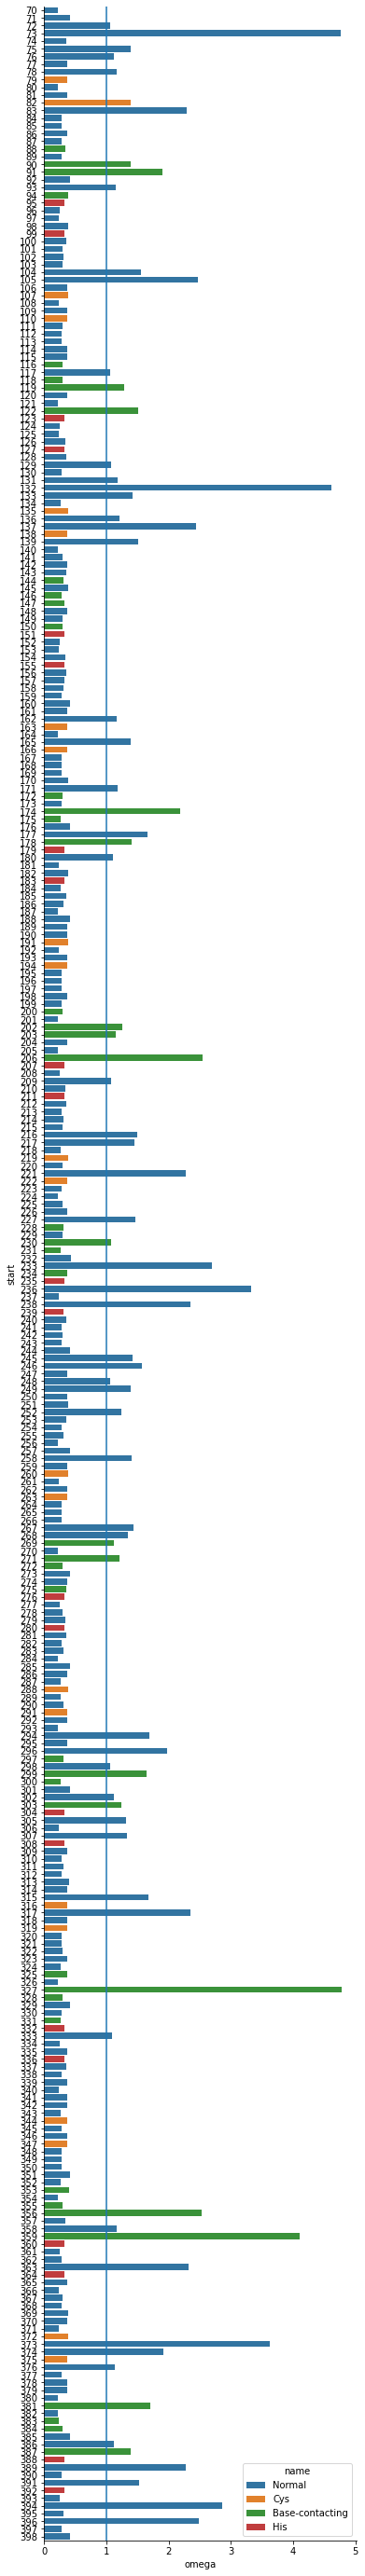

73
132
327


In [189]:
fig, ax = plt.subplots(figsize=(6, 50))
sns.barplot(data=rst_df.loc[rst_df.clade == 'clade6'], 
            x='omega',
            y='start', 
            hue='name',
            orient='horizontal',
            dodge=False,
            ax=ax)
ax.axvline(1)
sns.despine()
plt.show()

for i, row in rst_df.loc[rst_df.clade == 'clade6'].iterrows():
    if row.prob > 0.9:
        print(i)


In [176]:
for clade in set(rst_df.clade):
    try:
        frac_df = rst_df.loc[rst_df.clade == clade][['name', 'positive', 'omega']].groupby(['name', 'positive']).count().reset_index()
        fe = frac_df.loc[frac_df.name.isin(['Base-contacting', 'Normal'])] \
            .pivot(index='positive', columns='name', values='omega') \
            .sort_index(ascending=False).T
        o, p = stats.fisher_exact(fe)
        if p < 0.05:
            print(clade)
            print(fe)
            print(f'OR = {o}; p-value = {p}\n')
    except:
        pass

clade6
positive         True  False
name                        
Base-contacting    19     25
Normal             57    184
OR = 2.453333333333333; p-value = 0.009520805287689907

clade4
positive         True  False
name                        
Base-contacting    13     15
Normal             46    151
OR = 2.844927536231884; p-value = 0.019467616182688677



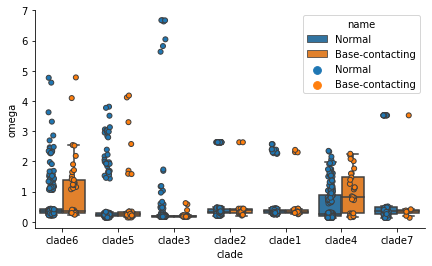

In [186]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=rst_df.loc[rst_df.name.isin(['Base-contacting', 'Normal'])],
            x='clade',
            y='omega',
            hue='name',
            fliersize=0,
            ax=ax)
sns.stripplot(data=rst_df.loc[rst_df.name.isin(['Base-contacting', 'Normal'])],
            x='clade',
            y='omega',
            hue='name',
            dodge=True,
            linewidth=1,
            ax=ax)

sns.despine()
plt.show()

In [5]:
def extract_fingers():
    znf_pat = re.compile('C.{2,4}C.{8,15}H.{3,5}H')
    species_pat = re.compile('([A-z]+_[a-z]+)_.*')
    fingers = defaultdict(list)
    
    for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa',
                              'fasta'):
        species = re.match(species_pat, record.id).group(1)
        hits = re.findall(znf_pat, str(record.seq))
        for hit in hits:
            fingers[species].append(hit)
    return fingers

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

In [6]:
fingers = extract_fingers()
c = 0
for i in fingers.values():
    c += len(i)
print('ZnFs =', c)

ZnFs = 59965


6238


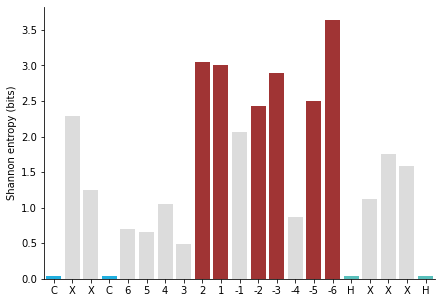

In [25]:
fingers21 = [f for f in fingers['Danio_rerio'] if len(f) == 21]
print(len(fingers21))
mat_df = logomaker.alignment_to_matrix(fingers21, to_type='probability').T
data = defaultdict(list)
for col in mat_df.columns:
    data['position'].append(col)
    data['entropy'].append(entropy(mat_df[col]))
    
znf_df = pd.DataFrame(data)
znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                     'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick', 'firebrick',
                     'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'firebrick', 'firebrick',
                     'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours)
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy (bits)')
ax.set_xticklabels(znf_df.pos_labels)
sns.despine()
plt.show()
fig.savefig('../figs/Danio_rerio_znf_entropy.pdf', bbox_inches='tight', dpi=300)

If we assume that measured entropy is indpendent of position within the zinc-finger fold, we can calculate the probability of observing that positions with the six highest entropy values would fall on positions 2,1,-2,-3,-5 and -6 by chance alone.

$P(binding = highest) = \frac{6!\times6!}{12!} = 0.00108$

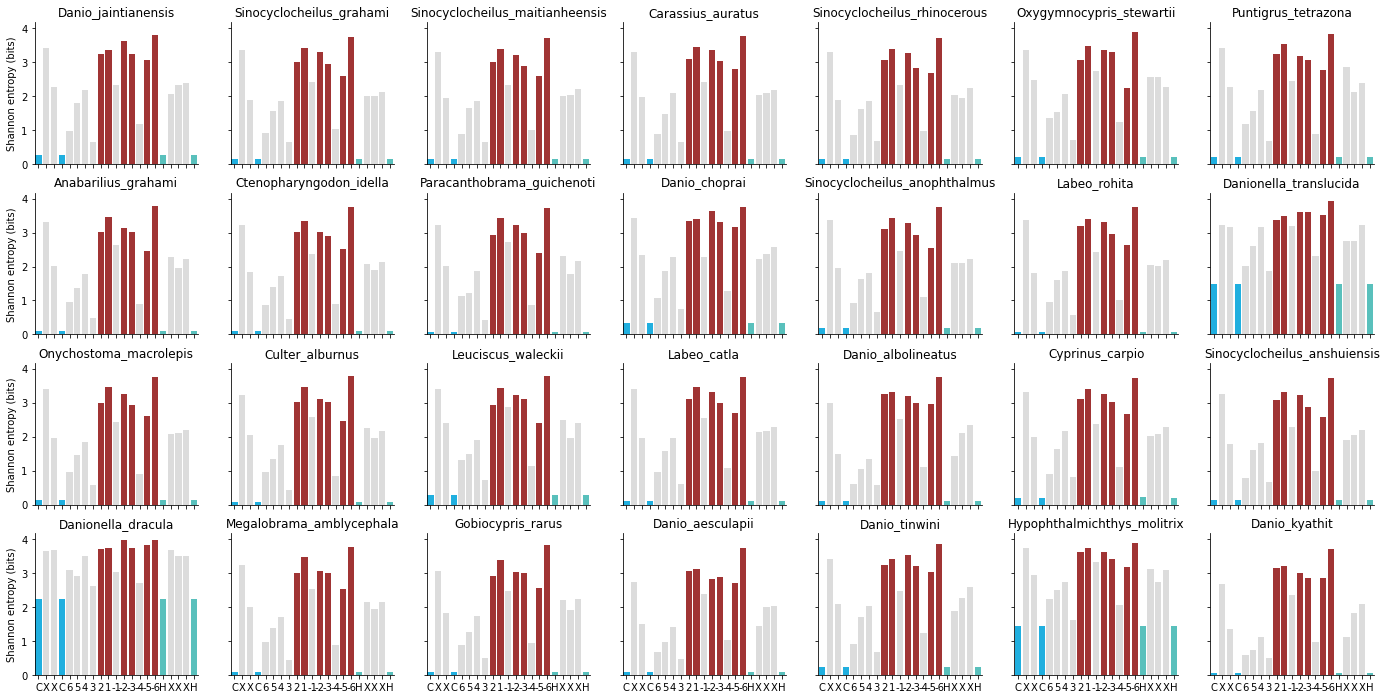

In [26]:
fig, ax = plt.subplots(figsize=(24, 12), nrows=4, ncols=7, sharex=True, sharey=True)
i, j = 0, 0
for species in fingers:
    if species == 'Danio_rerio':
        continue
    fingers21 = [f for f in fingers[species] if len(f) == 21]
    mat_df = logomaker.alignment_to_matrix(fingers21, to_type='probability').T
    data = defaultdict(list)
    for col in mat_df.columns:
        data['position'].append(col)
        data['entropy'].append(entropy(mat_df[col]))
    znf_df = pd.DataFrame(data)
    znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
    znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                         'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick', 'firebrick',
                         'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'firebrick', 'firebrick',
                         'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise']
    sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours, ax=ax[i][j])
    ax[i][j].set_title(species)
    ax[i][j].set_xlabel('')
    if i == 3: 
        ax[i][j].set_xticklabels(znf_df.pos_labels)
    if j != 0:
        ax[i][j].set_ylabel('')
    else:
        ax[i][j].set_ylabel('Shannon entropy (bits)')
    i += 1
    if i >= 4:
        j += 1
        i = 0
sns.despine()
plt.show()
fig.savefig('../figs/cyprinid_znf_entropy.pdf', bbox_inches='tight', dpi=300)

In [27]:
def footprint(seq):
    znf1 = re.compile('C..C.{8,15}H...H')
    fp_index = (-13, -12, -10, -9, -7, -6)
    hits = re.findall(znf1, seq)
    
    footprint = []
    for hit in hits:
        footprint.append(''.join([hit[i] for i in fp_index]))
    return tuple(footprint)

def extract_footprints(min_znfs=3):
    footprints = {}
    for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa',
                              'fasta'):
        fp = footprint(str(record.seq))
        if len(fp) >= min_znfs:
            footprints[record.id] = fp
    return footprints

(0.1, 400)

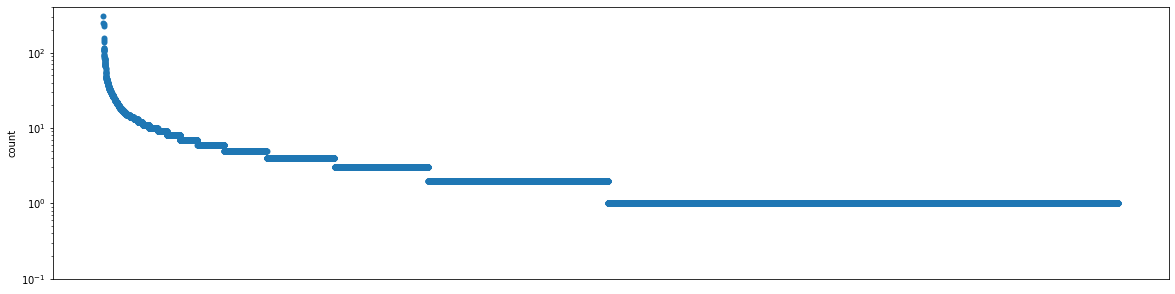

In [28]:
fps = extract_footprints()
all_fps = defaultdict(int)
for key, val in fps.items():
    pretty_fp = ','.join(val)
    for i in val:
        all_fps[i] += 1
data = pd.DataFrame({'footprint': [i for i in all_fps.keys()],
                     'count': [all_fps[i] for i in all_fps.keys()]}) \
         .sort_values('count', ascending=False) 

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yscale('log')
sns.scatterplot(data=data, x='footprint', y='count', linewidth=0)
ax.set_ylim((0.1, 400))
# print(all_fps)        
# for i in sorted(all_fps.items(), key=lambda x: x[1]):
#     print(i[0], i[1])
# print(len(all_fps))
# print(sum(all_fps.values()))